## Title

https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population


## Required Packages

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor
import re

## Import IIJA Data

In [176]:
iija_df = pd.read_excel("iija.xlsx").clean_names()
iija_df = iija_df.rename(columns={"state_teritory_or_tribal_nation":"state", "total_billions_":"total_funding"})
iija_df['state'] = iija_df['state'].str.title()

## Obtain US States and Territories Population

In [177]:
import requests
from io import StringIO

# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population"

# Send request
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
response = requests.get(url, headers=headers)
response.raise_for_status()

# Read the first table from the page
population_df = pd.read_html(StringIO(response.text))[0]

# Flatten multi-level columns and normalize names
population_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in population_df.columns]
population_df.columns = [re.sub(r'\[.*?\]', '', col.lower().replace(' ', '_').replace('\n', '_')).strip('_') for col in population_df.columns]

# Keep only the first two columns and rename
population_df = population_df.iloc[:56, :2]
population_df.columns = ['state', 'population']

# Clean 'state' column and convert 'population' to integer and match scale with IIJA
population_df['state'] = population_df['state'].str.replace(r'\[.*?\]', '', regex=True).str.strip()
population_df['population'] = population_df['population'].astype(int) / 1e9

# df.to_csv("us_population_by_state_clean.csv", index=False)

## Combine IIJA and Population Datasets

In [178]:
from rapidfuzz import process, fuzz

# Function to get best fuzzy match AND score
def fuzzy_match_with_score(name, choices, scorer=fuzz.token_sort_ratio):
    match = process.extractOne(name, choices, scorer=scorer)
    if match:
        return match[0], match[1]  # (best match, score)
    return None, None

# Apply fuzzy matching
df_states = population_df['state'].tolist()
iija_df[['matched_state', 'match_score']] = iija_df['state'].apply(
    lambda x: pd.Series(fuzzy_match_with_score(x, df_states))
)

# Add a flag for low confidence
iija_df['low_confidence'] = iija_df['match_score'] < 80

# Merge with df
merged_df = iija_df.merge(population_df, left_on='matched_state', right_on='state', how='left')

# Clean up columns
merged_df = merged_df.drop(columns=['state_y']).rename(columns={'state_x': 'state'})

# Final view
merged_df[['state', 'total_funding', 'matched_state', 'match_score', 'low_confidence', 'population']].sort_values('match_score').head()


,state,total_funding,matched_state,match_score,low_confidence,population
48,Tribal Communities,3.0000,Louisiana,44.444444,True,0.004598
8,Deleware,0.7920,Delaware,87.500000,False,0.001052
49,Us Virgin Islands,0.1483,U.S. Virgin Islands,88.888889,False,0.000105
9,District Of Columbia,1.1000,District of Columbia,95.000000,False,0.000702
0,Alabama,3.0000,Alabama,100.000000,False,0.005158


In [179]:
merged_filter_df = merged_df[merged_df['low_confidence']  == False]

In [180]:
state_df = merged_filter_df[['matched_state', 'total_funding', 'population']]
state_df = state_df.rename(columns={'matched_state':'state'})
state_df

,state,total_funding,population
0,Alabama,3.0000,0.005158
1,Alaska,3.7000,0.000740
2,American Samoa,0.0686,0.000048
3,Arizona,3.5000,0.007582
4,Arkansas,2.8000,0.003088
5,California,18.4000,0.039431
6,Colorado,3.2000,0.005957
7,Connecticut,2.5000,0.003675
8,Delaware,0.7920,0.001052
9,District of Columbia,1.1000,0.000702


https://github.com/tonmcg/US_County_Level_Election_Results_08-24

https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-24/refs/heads/master/2020_US_County_Level_Presidential_Results.csv

## Obtain 2020 Election Results Data

In [181]:
election_results_df = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-24/refs/heads/master/2020_US_County_Level_Presidential_Results.csv")
election_results_df


,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022
...,...,...,...,...,...,...,...,...,...,...
3147,Wyoming,56037,Sweetwater County,12229,3823,16603,8406,0.736554,0.230260,0.506294
3148,Wyoming,56039,Teton County,4341,9848,14677,-5507,0.295769,0.670982,-0.375213
3149,Wyoming,56041,Uinta County,7496,1591,9402,5905,0.797277,0.169219,0.628058
3150,Wyoming,56043,Washakie County,3245,651,4012,2594,0.808824,0.162263,0.646560


In [182]:
election_df = election_results_df[['state_name', 'county_name', 'votes_gop', 'votes_dem']]

In [183]:
election_df = election_df.groupby('state_name').sum(numeric_only=True)
election_df

,votes_gop,votes_dem
state_name,,
Alabama,1441168,849648
Alaska,189892,153405
Arizona,1661686,1672143
Arkansas,760647,423932
California,6005961,11109764
Colorado,1364607,1804352
Connecticut,715291,1080680
Delaware,200603,296268
District of Columbia,18586,317323


## Combine Election Data with IIJA and Population Dataset

In [184]:
analysis_df = state_df.merge(election_df, left_on='state', right_on='state_name', how='left')
analysis_df

,state,total_funding,population,votes_gop,votes_dem
0,Alabama,3.0000,0.005158,1441168.0,849648.0
1,Alaska,3.7000,0.000740,189892.0,153405.0
2,American Samoa,0.0686,0.000048,NaN,NaN
3,Arizona,3.5000,0.007582,1661686.0,1672143.0
4,Arkansas,2.8000,0.003088,760647.0,423932.0
5,California,18.4000,0.039431,6005961.0,11109764.0
6,Colorado,3.2000,0.005957,1364607.0,1804352.0
7,Connecticut,2.5000,0.003675,715291.0,1080680.0
8,Delaware,0.7920,0.001052,200603.0,296268.0
9,District of Columbia,1.1000,0.000702,18586.0,317323.0


In [185]:
analysis_df[['votes_gop', 'votes_dem']] = analysis_df[['votes_gop', 'votes_dem']] / 1e9

In [187]:
analysis_df

,state,total_funding,population,votes_gop,votes_dem
0,Alabama,3.0000,0.005158,0.001441,0.000850
1,Alaska,3.7000,0.000740,0.000190,0.000153
2,American Samoa,0.0686,0.000048,NaN,NaN
3,Arizona,3.5000,0.007582,0.001662,0.001672
4,Arkansas,2.8000,0.003088,0.000761,0.000424
5,California,18.4000,0.039431,0.006006,0.011110
6,Colorado,3.2000,0.005957,0.001365,0.001804
7,Connecticut,2.5000,0.003675,0.000715,0.001081
8,Delaware,0.7920,0.001052,0.000201,0.000296
9,District of Columbia,1.1000,0.000702,0.000019,0.000317


In [188]:
analysis_df.describe()

,total_funding,population,votes_gop,votes_dem
count,56.000000,56.000000,51.000000,51.000000
mean,3.447007,0.006137,0.001455,0.001593
std,3.323185,0.007457,0.001413,0.001916
min,0.068600,0.000045,0.000019,0.000073
25%,1.300000,0.001408,0.000474,0.000399
50%,2.700000,0.003885,0.001020,0.000856
75%,3.925000,0.007316,0.001791,0.002376
max,18.400000,0.039431,0.006006,0.011110


## Dataset for Analysis

In [189]:
from IPython.display import display, HTML

display(HTML("""
<div style="max-height: 200px; overflow-y: auto;">
    {table}
</div>
""".format(table=analysis_df.to_html())))


,state,total_funding,population,votes_gop,votes_dem
0,Alabama,3.0000,0.005158,0.001441,0.000850
1,Alaska,3.7000,0.000740,0.000190,0.000153
2,American Samoa,0.0686,0.000048,NaN,NaN
3,Arizona,3.5000,0.007582,0.001662,0.001672
4,Arkansas,2.8000,0.003088,0.000761,0.000424
5,California,18.4000,0.039431,0.006006,0.011110
6,Colorado,3.2000,0.005957,0.001365,0.001804
7,Connecticut,2.5000,0.003675,0.000715,0.001081
8,Delaware,0.7920,0.001052,0.000201,0.000296
9,District of Columbia,1.1000,0.000702,0.000019,0.000317


### Population by State

The top 5% population sizes are California (39.4M), Texas (31.3M), and Florida (23.4M) within the U.S. states and its territories.

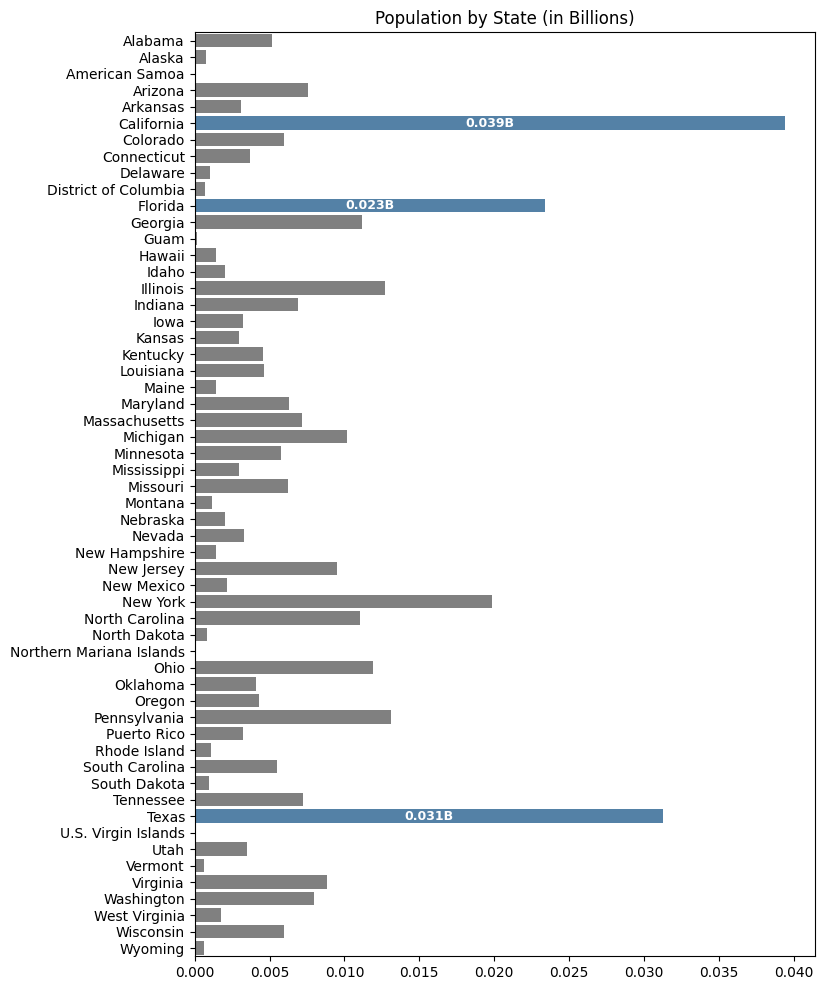

In [190]:
plt.figure(figsize=(8, 12))

# Calculate 95th percentile threshold
threshold = np.percentile(analysis_df['population'], 95)

# Add a column to indicate top 5%
analysis_df['top5pct'] = analysis_df['population'] >= threshold

# Use hue for coloring instead of palette alone
ax = sns.barplot(
    data=analysis_df,
    x='population',
    y='state',
    hue='top5pct',
    dodge=False,
    palette={True: 'steelblue', False: 'gray'},
    legend=False
)

# Annotate top 5% bars inside the bar with white font
for i, (value, is_top) in enumerate(zip(analysis_df['population'], analysis_df['top5pct'])):
    if is_top:
        ax.text(
            value * 0.5,  # middle of the bar
            i,
            f"{value:.3f}B",
            va='center',
            ha='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

# Plot Features
plt.title("Population by State (in Billions)")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

### Funding Allocation by State

The Top 5% within the U.S. states and territories receving funding allocation are California ($18.4B), Texas ($14.2B), and New York ($10.1B). 

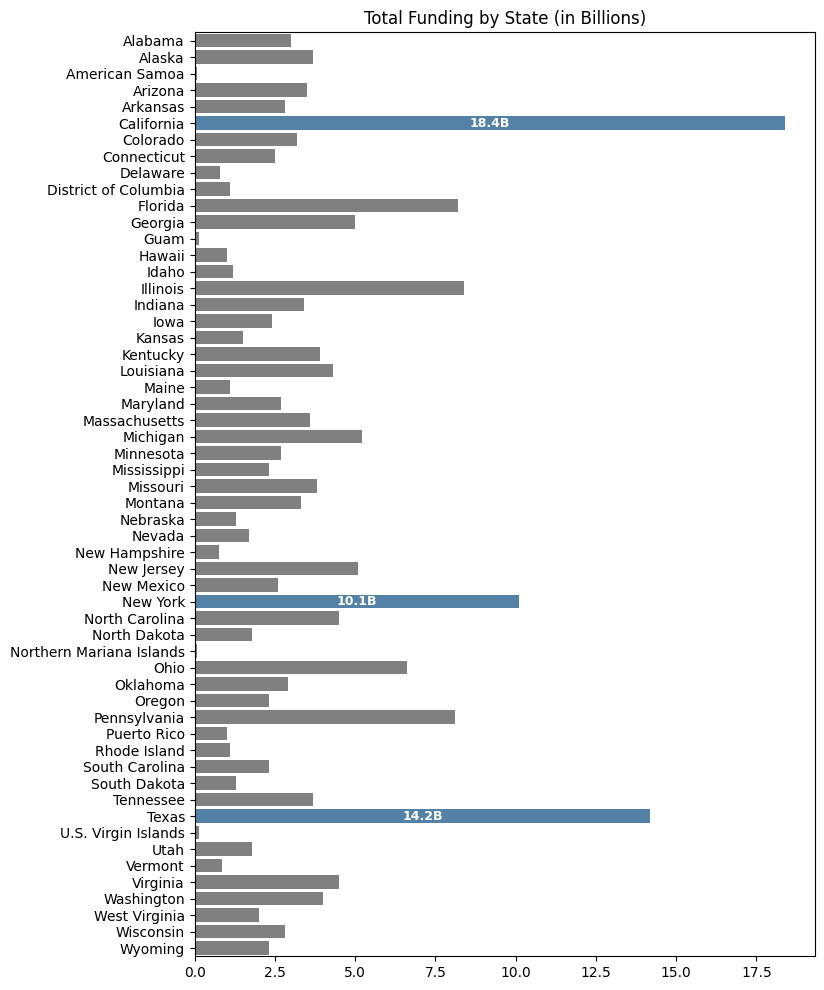

In [194]:
plt.figure(figsize=(8, 12))

# Calculate 95th percentile threshold
threshold = np.percentile(analysis_df['total_funding'], 95)

# Add a column to indicate top 5%
analysis_df['top5pct'] = analysis_df['total_funding'] >= threshold

# Use hue for coloring instead of palette alone
ax = sns.barplot(
    data=analysis_df,
    x='total_funding',
    y='state',
    hue='top5pct',
    dodge=False,
    palette={True: 'steelblue', False: 'gray'},
    legend=False
)

# Annotate top 5% bars inside the bar with white font
for i, (value, is_top) in enumerate(zip(analysis_df['total_funding'], analysis_df['top5pct'])):
    if is_top:
        ax.text(
            value * 0.5,  # middle of the bar
            i,
            f"{value:.1f}B",
            va='center',
            ha='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

# Plot Features
plt.title("Total Funding by State (in Billions)")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

### Is the allocation equitable based on the population of each of the States and Territories, or is bias apparent?

We will calculate the funding ratio of dollars spent per person within a state. The formula
$$
funding\_ratio = total\_funding / population
$$ 
where total_funding and population is based by its respective state/territory. 

In [191]:
analysis_df['funding_ratio'] = analysis_df['total_funding'] /analysis_df['population']

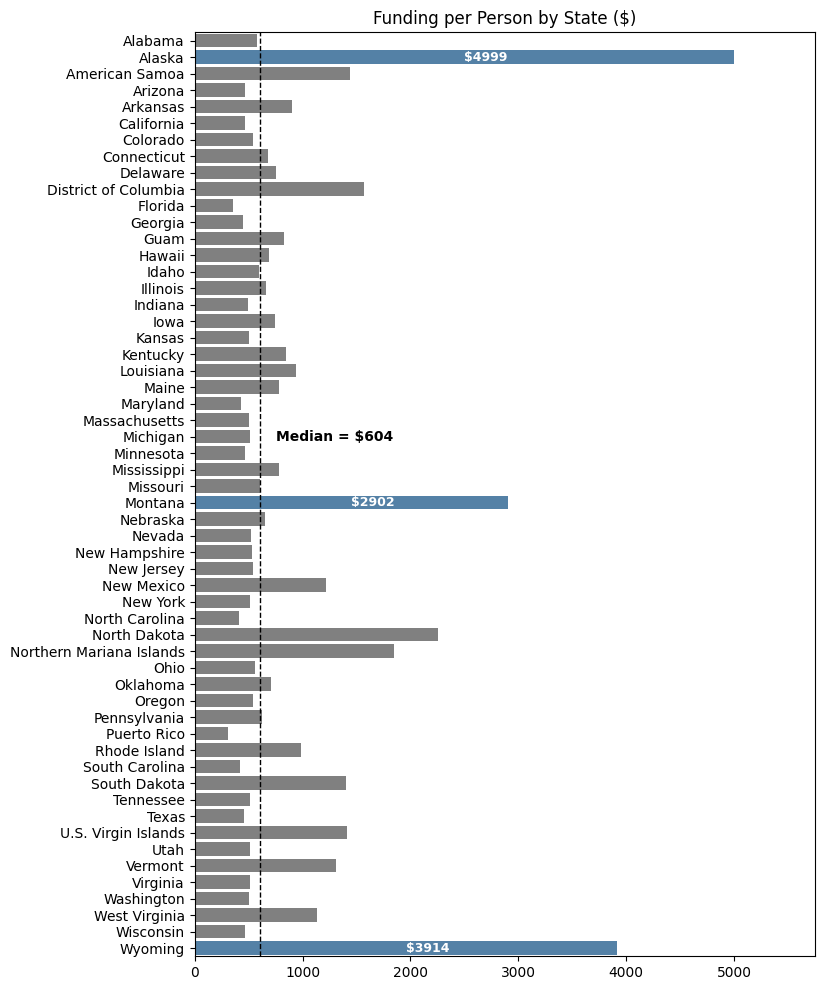

In [192]:
plt.figure(figsize=(8, 12))

# Compute 95th percentile
top5pct_threshold = analysis_df["funding_ratio"].quantile(0.95)

# Identify states in the top 5%
top5pct_states = analysis_df[analysis_df["funding_ratio"] >= top5pct_threshold]["state"]

ax = sns.barplot(
    data=analysis_df,
    x="funding_ratio",
    y="state",
    hue=analysis_df["state"].isin(top5pct_states),
    dodge=False,
    palette={True: "steelblue", False: "gray"},
    legend=False
)

# Annotate top 5% states
for i, (value, state) in enumerate(zip(analysis_df["funding_ratio"], analysis_df["state"])):
    if state in top5pct_states.values:
        ax.text(
            value * 0.5,
            i,
            f"${round(value)}",
            va="center",
            ha="left",
            fontsize=9,
            color="white",
            fontweight='bold'
        )

# Adjust x-axis
max_val = analysis_df["funding_ratio"].max()
ax.set_xlim(0, max_val * 1.15)

# Median line
median_val = analysis_df["funding_ratio"].median()
ax.axvline(median_val, color="black", linestyle="--", linewidth=1)

# Median annotation
ax.text(
    median_val + 0.03 * max_val,
    24,
    f"Median = ${round(median_val)}",
    ha="left",
    va="center",
    fontsize=10,
    color="black",
    fontweight="bold",
    backgroundcolor="white"
)

# Plot Features
plt.title("Funding per Person by State ($)")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

### Does the allocation favor the political interests of the Biden administration?

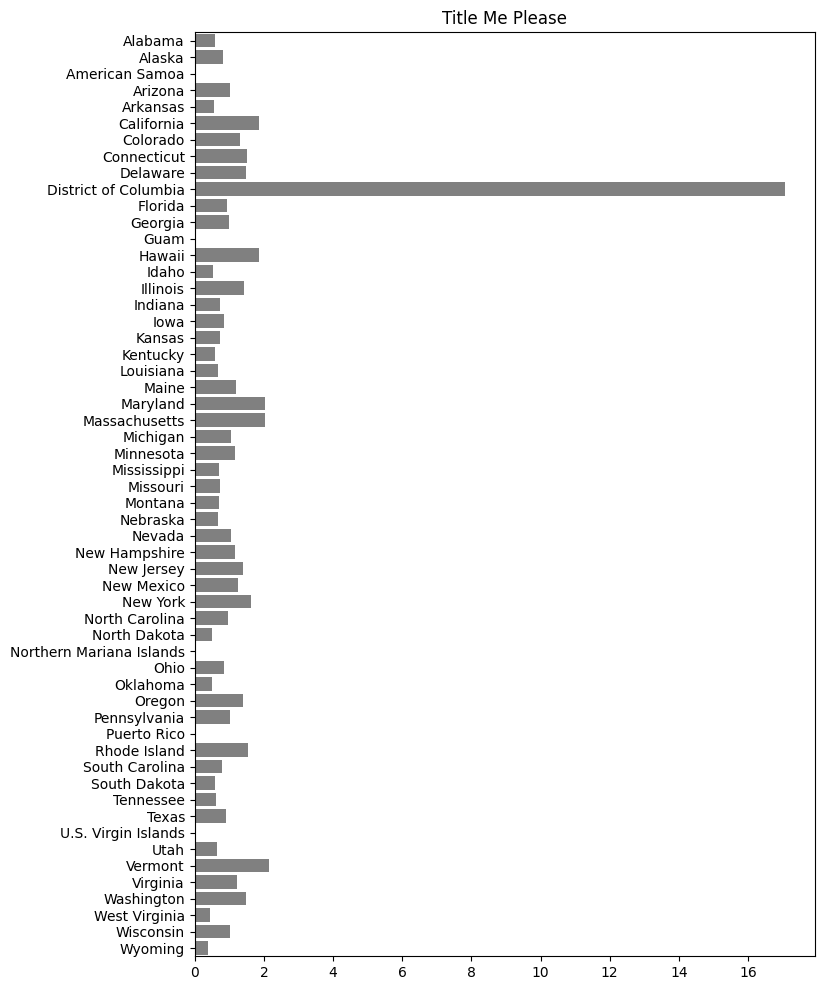

In [202]:
analysis_df['political_ratio'] = analysis_df['votes_dem'] / analysis_df['votes_gop']

plt.figure(figsize=(8, 12))

# Calculate 95th percentile threshold
threshold = np.percentile(analysis_df['political_ratio'], 95)

# Add a column to indicate top 5%
analysis_df['top5pct'] = analysis_df['political_ratio'] >= threshold

# Use hue for coloring instead of palette alone
ax = sns.barplot(
    data=analysis_df,
    x='political_ratio',
    y='state',
    hue='top5pct',
    dodge=False,
    palette={True: 'steelblue', False: 'gray'},
    legend=False
)

# Annotate top 5% bars inside the bar with white font
for i, (value, is_top) in enumerate(zip(analysis_df['political_ratio'], analysis_df['top5pct'])):
    if is_top:
        ax.text(
            value * 0.5,  # middle of the bar
            i,
            f"{value:.2f}",
            va='center',
            ha='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )

# Plot Features
plt.title("Title Me Please")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()